In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from tqdm.notebook import tqdm

from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi

from qc_grader.challenges.spring_2022.helpers import generate_disordered_tb_instruction

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Many-body quantum dynamics

In this exercise we examine lattice disorder and particle-particle interaction. A closed quantum many-body system initialized in a non-equilibrium state will reach the equilibrium state, refered to as thermalization, under its own dynamics. This behavior is as a result of the laws of statistical mechanics, and analogous to a hot cup of coffee cooling down to the surrounding temperature if left unattended. 

However, the presence of lattice disorder prevents the system from evolving into an ergodic thermalized state. This interplay between disorder and particle interaction results in many-body localization (MBL), and it allows the system to retain a memory of its initial condition at all times. For more information about MBL refer to [1]

Let's again consider the tight-binding Hamiltonian with arbitrary site energies:

$$H_{\rm tb}/\hbar = \sum^{3}_{i=0} (X_i X_{i+1} + Y_i Y_{i+1}) + \sum_i \epsilon_i Z_i $$

As we explored in exercise 2, we can emulate disorder in this system by setting $\epsilon_i=W \rm{cos}(2\pi\beta i)$, where $W$ is the disorder strength, and $\beta$ determines the quasicrystal periodicity. We can add multiple particles to the system by initalizing multiple qubits to the $|1\rangle$ state prior to the unitary time evolution. Under $H_{\rm tb}$, each site can only be occupied by a single particle, resulting in particle repulsion interaction.

[1] https://arxiv.org/abs/1804.11065

One of the signatures of the breakdown of thermalization is the emergence of **imbalance**. In a thermalized system, we expect each site of the lattice to be occupied by the same average number of particles after reaching steady state. However, adding disorder to the interacting system will result in deviations from the thermal value observed on each site. The system imbalance can be quantified using the following expression:

$$\mathcal{I}= \langle (N_e-N_o)/(N_e+N_o) \rangle$$

where $N_e$ and $N_o$ are the even and odd site populations of the system. For a thermalized system this $\mathcal{I}=0$, and system disorder will cause deviations from this value.

Let's consider a few examples:

1. $ |\psi\rangle = |0111\rangle $: 
\begin{align*}
\langle \psi | N_e | \psi \rangle &= 1 \\
\langle \psi | N_o | \psi \rangle &= 2 \\
\mathcal{I} = \langle \psi |  (N_e-N_o)/(N_e+N_o) | \psi \rangle &= -1/3
\end{align*}

2. $ |\psi\rangle = \sqrt{2/3} |0111\rangle + \sqrt{1/3} |1011\rangle $: 
$$ \langle \psi |  \mathcal{I} | \psi \rangle = 2/3 * \langle 0111 |  \mathcal{I} |0111\rangle + 1/3 * \langle 1011 |  \mathcal{I} |1011\rangle $$
\begin{align*}
\langle 0111 |  \mathcal{I} |0111\rangle &= -1/3 \\
\langle 1011 |  \mathcal{I} |1011\rangle &= 1/3 \\
 \langle \psi |  \mathcal{I} | \psi \rangle &= -1/9
\end{align*}

<div class="alert alert-block alert-danger">
    
<b>Challenge question 3a</b> 

Write a function that outputs the imbalance of a quantum state
    
</div>

In [2]:
def get_imbalance(state):
    ###EDIT CODE BELOW
    ### HINT: MAKE SURE TO SKIP CALCULATING IMBALANCE OF THE |00...0> STATE
    num_qubits=state.num_qubits
    temp=state.probabilities_dict()
    temp2=[]
    temp3=[]
    for i,j in temp.items():
        bits=np.array(list(i))
        bits=bits.astype(np.int)
        if np.all(bits==0):
            temp3.append(0)
            temp2.append(j)
            continue
        nm=0
        nn=0
        temp2.append(j)
        for i in range(0,len(bits)):
            if bits[i]==1:
                if i%2==0:
                    nm+=1
                else:
                    nn+=1
        temp3.append((nm-nn)/(nm+nn))
    imbalance_val=np.average(temp3,weights=temp2)
    
    
    ###DO NOT EDIT BELOW
    
    return imbalance_val

In [3]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex3a

grade_ex3a(get_imbalance) 


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Next, we consider how quantum information and entanglement entropy grows in the system. In an entangled system, ignoring information about the remaining system puts the subsystem into a mixed state of different number states. We can probe the **von Neumann entropy** to gain insight into the degree of entanglement between subsystem $A$ and the remaining of the system:

$$\mathcal{S}_{\rm vn}(\rho_A)= -\rm{tr}(\rho_A \rm{ln} \rho_A)$$

Here, $\rho_A= \rm{tr}_{\bar{A}} \rho$ is the reduced density matrix describing subsytem $A$ when we trace out the rest of the system. If a subsytem $A$ is fully entangled with the rest of the system, $\mathcal{S}_{\rm vn}(\rho_A) = \rm{ln}2$, whereas if the subsytem is completely separable (in a product state) with respect to its environment $\mathcal{S}_{\rm vn}(\rho_A)=0$. Consider the example below:

In [4]:
bell_state = qi.Statevector(np.array([0,1,1,0])/np.sqrt(2))

rho_0 = qi.partial_trace(bell_state,[1]) # We trace out qubit 1
rho_1 = qi.partial_trace(bell_state,[0]) # We trace out qubit 0

print('QB0 vn entropy: ', qi.entropy(rho_0, base=np.exp(1)))
print('QB1 vn entropy: ', qi.entropy(rho_1, base=np.exp(1)))

QB0 vn entropy:  0.6931471805599454
QB1 vn entropy:  0.6931471805599454


## Probing the many-body quantum dynamics in a 12 qubit chain

For this part of the exercise, we use the same lattice disorder pattern as we explored in exercise 2.

In [5]:
t = Parameter('t')

In [6]:
num_qubits=12
deltas=[Parameter('delta_{:d}'.format(idx)) for idx in range(num_qubits)]
disorder_trot_step=generate_disordered_tb_instruction(t, deltas, num_qubits)

In [7]:
# Here we define the disorder pattern

beta=(np.sqrt(5)-1)/2 # DO NOT EDIT
AA_pattern=np.cos(2*np.pi*beta*np.arange(num_qubits)) # DO NOT EDIT

<div class="alert alert-block alert-danger">
    
<b>Challenge question 3b</b> 

Initialize the system by setting qubits 0, 4, and 8 to $|1\rangle$.
    
</div>

In [8]:
delta_t=0.1
time_steps=np.arange(0,21,2)

circuits={}
Ws=[1,4,10]

for W in Ws:
    disorders=W*AA_pattern
    
    circuits[W]=[]

    for n_steps in time_steps:

        qr = QuantumRegister(num_qubits)
        qc = QuantumCircuit(qr)

        ###EDIT CODE BELOW
        qc.x([0,4,8])
        ###DO NOT EDIT BELOW     

        for _ in range(n_steps):
            qc.append(disorder_trot_step, [i for i in range(num_qubits)])
        
        if n_steps!=0:
            qc = qc.bind_parameters({t: delta_t})
            qc = qc.bind_parameters({deltas[idx]: disorders[idx] for idx in range(num_qubits)})

        circuits[W].append(qc)

<div class="alert alert-block alert-danger">
    
<b>Challenge question 3c</b> 

Extract the von Neumann entropy of qubit 0 at different evolution time steps for different disorder strengths.
    
</div>

<div class="alert alert-block alert-danger">
    
<b>Challenge question 3d</b> 

Extract the imbalance of the lattice at different evolution time steps for different disorder strengths.
    
</div>

In [9]:
from qiskit import transpile

# Use Aer's statevector simulator
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend_sim = Aer.get_backend('statevector_simulator')

probability_densities={}
state_vector_imbalances={}
vn_entropies={}

for W in tqdm(Ws):
    probability_densities[W]=[]
    state_vector_imbalances[W]=[]
    vn_entropies[W]=[]
    
    for circ in circuits[W]:

        transpiled_circ=transpile(circ, backend_sim, optimization_level=3)

        job_sim = backend_sim.run(transpiled_circ)

        # Grab the results from the job.
        result_sim = job_sim.result()
        outputstate = result_sim.get_statevector(transpiled_circ, decimals=6)
        ps=[]
        for idx in range(num_qubits):
            ps.append(np.abs(qi.partial_trace(outputstate,[i for i in range(num_qubits) if i!=idx]))[1,1]**2)
        
        entropy=0
        ### EDIT CODE BELOW (extract the density matrix of qubit 0 by tracing out all other qubits)
        bs=qi.partial_trace(outputstate,[i for i in range(num_qubits) if i!=0])
        entropy=qi.entropy(bs, base=np.exp(1))
        ###DO NOT EDIT BELOW 
        
        imbalance=0
        ### EDIT CODE BELOW 
        imbalance=get_imbalance(outputstate)
        ###DO NOT EDIT BELOW
        
        
        vn_entropies[W].append(entropy)
        probability_densities[W].append(ps)
        state_vector_imbalances[W].append(imbalance)

  0%|          | 0/3 [00:00<?, ?it/s]

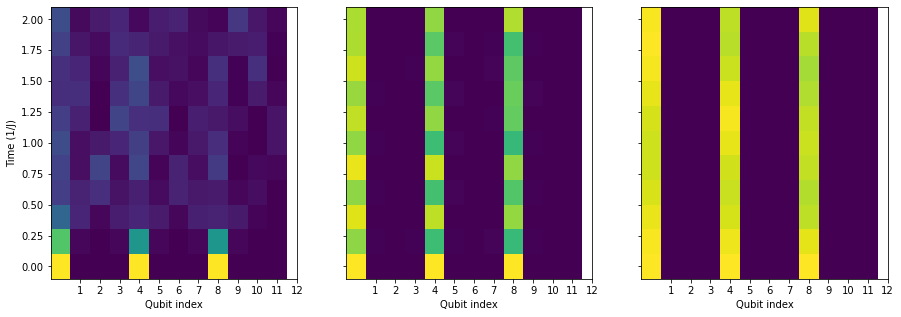

In [10]:
fig, axs = plt.subplots(1,3,figsize=(15,5), facecolor='white', sharey=True)

for i,W in enumerate(Ws):
    ax=axs[i]
    ax.pcolormesh(np.arange(0,num_qubits,1), time_steps*delta_t ,probability_densities[W])
    ax.set_xlabel('Qubit index')
    ax.set_xticks(np.arange(1,num_qubits+1,1))

axs[0].set_ylabel('Time (1/J)')

plt.show()

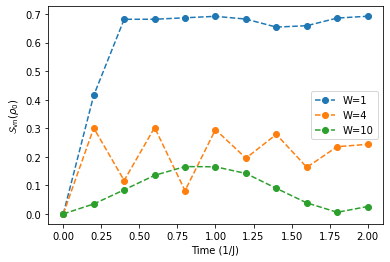

In [11]:
for W in Ws:
    plt.plot(time_steps*delta_t,vn_entropies[W], '--o', label='W={:d}'.format(W))

plt.xlabel(r'Time (1/J)')
plt.ylabel(r'$\mathcal{S}_{\rm vn}(\rho_0)$')
plt.legend()
plt.show()

In [12]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex3b

grade_ex3b(vn_entropies)


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


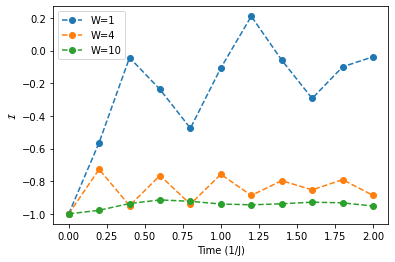

In [13]:
for W in Ws:
    plt.plot(time_steps*delta_t,state_vector_imbalances[W], '--o', label='W={:d}'.format(W))

plt.xlabel(r'Time (1/J)')
plt.ylabel(r'$\mathcal{I}$')
plt.legend()
plt.show()

In [14]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex3c

grade_ex3c(state_vector_imbalances)


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
